In [ ]:
import tensorflow as tf
# print(tf.__version__)

2.18.0


In [2]:
import torch
import torch.nn as nn

In [3]:
#GELU Activation function
class GELU(nn.Module):
    def __init__(self,):
        super().__init__()
    def forward(self, x):
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.0447*torch.pow(x,3))))

In [4]:
#Feed Forward Neural network
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']), #incresing dimesion
                                    GELU(),
                                    nn.Linear(4*cfg['emb_dim'],cfg['emb_dim']))  #coming back to original dimension
    def forward(self,x):
        return self.layers(x)

In [5]:
# Layer Normalization
class LayerNorm(nn.Module):
    def __init__(self, emd_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emd_dim))
        self.shift = nn.Parameter(torch.zeros(emd_dim))
    def forward(self, x):
        mean = x.mean(dim = -1, keepdim =True)
        var = x.var(dim =-1, keepdim = True, unbiased= False)
        norm_x = (x-mean)/(torch.sqrt(var+self.eps))
        return self.scale*norm_x + self.shift

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias = False):
        super().__init__()
        assert(d_out % num_heads==0),\
            "d_out must be divisible by nums head"
        
        self.d_out = d_out
        self.num_head = num_heads
        self.head_dim = d_out//num_heads
        # self.d_in = d_in
        self.w_query = nn.Linear(d_in,d_out, bias=qkv_bias)
        self.w_key = nn.Linear(d_in,d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in,d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self,x):
        b,num_token,d_in = x.shape

        keys = self.w_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.w_query(x)
        values = self.w_value(x)

        keys = keys.view(b,num_token,self.num_head,self.head_dim)
        queries = queries.view(b,num_token,self.num_head,self.head_dim)
        values = values.view(b,num_token,self.num_head,self.head_dim)

        #grouping by num_heads
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)

        # calculating attention score
        attn_score = queries @ keys.transpose(2,3)

        # calculating attention weigths,masking, scaling and dropout
        mask_bool = self.mask.bool()[:num_token,:num_token]
        attn_score= attn_score.masked_fill_(mask_bool, - torch.inf)
        attn_weight = torch.softmax(attn_score/keys.shape[-1]**0.5, dim=-1)
        attn_weight = self.dropout(attn_weight)
        
        #calculating the context vector
        context_vector = attn_weight @ values #ntokn x ntoken * ntoken x head_dim
        # trasposing to get all the context vextor togeth
        context_vector = context_vector.transpose(1,2)

        # combining heads 
        context_vector = context_vector.contiguous().view(b,num_token,self.d_out)
        context_vector = self.out_proj(context_vector) # optional projection
        return context_vector

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.attn = MultiHeadAttention(d_in=cfg['emb_dim'], d_out= cfg['emb_dim'],
                                       context_length=cfg['context_length'],
                                       num_heads=cfg['n_heads'], dropout= cfg['drop_rate'],
                                       qkv_bias= cfg['qkv_bias'])
        self.ff = FeedForward(cfg=cfg)
        self.norm1 = LayerNorm(emd_dim=cfg['emb_dim'])
        self.norm2 = LayerNorm(emd_dim=cfg['emb_dim'])

        self.drop_shortcut  = nn.Dropout(cfg['drop_rate'])
    
    def forward(self,x):
        shortcut = x
        x= self.norm1(x)
        x = self.attn(x)
        x = self.drop_shortcut(x)

        x = x+ shortcut

        shortcut =x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


In [8]:
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm  = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'], bias=False)
    def forward(self,in_idx):
        batch_size, seq_len = in_idx.shape
        token_embded = self.tok_emb(in_idx)
        pos_embded = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        x = token_embded+pos_embded
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



In [9]:
# gpt-2 configurations
GPT_CONFIG_124M= {
    'vocab_size' :50257,
    'context_length': 256,
    'emb_dim':768,
    'n_heads':12,
    'n_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False
}

In [10]:
from zz3_weightDownload import download_and_load_gpt2

In [11]:
from zz3_weightDownload import download_and_load_gpt2

In [12]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt_2")

c:\Users\hp\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date


c:\Users\hp\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date


c:\Users\hp\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date


c:\Users\hp\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date


c:\Users\hp\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date


c:\Users\hp\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date


c:\Users\hp\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date


In [13]:
print("Settings:", settings)
print("Parameters dictionry keys :", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameters dictionry keys : dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [14]:
print(params['wte'])
print(params['wte'].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
(50257, 768)


In [15]:
#defining model configuration in a dictionary
model_config = {
    "gpt-2-small(124M)":{"emb_dim":768, "n_layers":12,"n_heads":12},
    "gpt-2-medium(355M)":{"emb_dim":768, "n_layers":24,"n_heads":16},
    "gpt-2-large(124M)":{"emb_dim":768, "n_layers":36,"n_heads":20},
    "gpt-2-xl(124M)":{"emb_dim":768, "n_layers":48,"n_heads":25}
}

In [16]:
#updating base configuration with specific model settings
model_name = "gpt-2-small(124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_config[model_name])

In [17]:
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [18]:
NEW_CONFIG.update({"context_length":1024, "qkv_bias":True})

In [19]:
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': True}

In [20]:
myGpt_2 = GPTModel(NEW_CONFIG)

In [21]:
myGpt_2.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (w_query): Linear(in_features

In [22]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch: left = {left.shape}, right = {right.shape}")
    with torch.no_grad():
        left.copy_(torch.tensor(right))
    return left


In [23]:
import numpy as np

def load_weights_to_gpt(gpt,params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight,params['wpe'] )
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    # loading weights to transformer blocks and it's each layer
    for b in range(len(params['blocks'])):
        #upadting key,query and value weights and bias
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].attn.w_query.weight = assign(
            gpt.trf_blocks[b].attn.w_query.weight, q_w.T)
        gpt.trf_blocks[b].attn.w_key.weight = assign(
            gpt.trf_blocks[b].attn.w_key.weight, k_w.T)
        gpt.trf_blocks[b].attn.w_value.weight = assign(
            gpt.trf_blocks[b].attn.w_value.weight, v_w.T)
        
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attn.w_query.bias = assign(
            gpt.trf_blocks[b].attn.w_query.bias, q_b)
        gpt.trf_blocks[b].attn.w_key.bias = assign(
            gpt.trf_blocks[b].attn.w_key.bias, k_b)
        gpt.trf_blocks[b].attn.w_value.bias = assign(
            gpt.trf_blocks[b].attn.w_value.bias, v_b)
        
        #updating out projection weights and bias
        gpt.trf_blocks[b].attn.out_proj.weight = assign(
            gpt.trf_blocks[b].attn.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].attn.out_proj.bias = assign(
            gpt.trf_blocks[b].attn.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])
        
        # updating weight of feed forward neural network 
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        # updating weights for layer normalization scale and shift
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])
    # End of transformer blocks
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params['g'])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params['b'])
    gpt.out_head.weight = assign(gpt.out_head.weight, params['wte'])

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
load_weights_to_gpt(myGpt_2, params=params)

In [26]:
def text_to_token(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor
def token_to_text(ids, tokenizer):
    flat = ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [27]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [28]:
def generate(model,idx,max_new_token,context_size,temp=0.0,top_k=None,eos_id= None):
    for _ in range(max_new_token):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]
        # applying filter for top k
        if top_k is not None:
            top_logits,_  = torch.topk(logits,top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(logits<min_val,torch.tensor(float("-inf")).to(device),logits)
        # Apply temprature scaling
        if temp>0.0:
            logits = logits/temp
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next==eos_id:
            break
        idx = torch.cat((idx,idx_next),dim=-1)

    return idx


In [29]:
torch.manual_seed(123)
token_ids   = generate(model=myGpt_2, idx=text_to_token("That day was special and a bit lucky for me",tokenizer).to(device),
                       max_new_token=50,context_size=NEW_CONFIG['context_length'],
                       top_k=50,temp=1.5)
print('Output Text: ', token_to_text(token_ids,tokenizer))

Output Text:  That day was special and a bit lucky for me," Icahn told Sporting News from his home in Austin, Texas. "It started off as a little set of circumstances that I couldn't live by, but actually played through it that way. Now I understand it now on how my mom helped


## Fine Tunning the model for classification task

In [30]:
import pandas as pd
df = pd.read_csv('SMSSpamCollection', sep='\t',header=None, names=['label','text'])

In [31]:
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [32]:
print(df['label'].value_counts())

ham     4825
spam     747
Name: label, dtype: int64


In [33]:
def create_balanced_dataset(df):
    num_spam = df[df['label']=='spam'].shape[0]
    ham_subset = df[df['label']=='ham'].sample(num_spam,random_state = 123)
    balanced_df = pd.concat([ham_subset, df[df['label']=='spam']])
    return balanced_df

In [34]:
balanced_df = create_balanced_dataset(df)
balanced_df

,label,text
4307,ham,Awww dat is sweet! We can think of something t...
4138,ham,Just got to &lt;#&gt;
4831,ham,"The word ""Checkmate"" in chess comes from the P..."
4461,ham,This is wishing you a great day. Moji told me ...
5440,ham,Thank you. do you generally date the brothas?
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [35]:
balanced_df['label'] = balanced_df['label'].map({'ham':0, 'spam':1})

In [36]:
balanced_df.head()

,label,text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


In [37]:
def random_split(df, train_frac, val_frac):
    df = df.sample(frac=1,random_state=123).reset_index(drop=True)
    train_end = int(len(df)*train_frac)
    validation_end = train_end + int(len(df)*val_frac)
    #splitting the dataframe
    train_df  = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df,validation_df,test_df

In [38]:
train_df,validation_df,test_df = random_split(balanced_df,0.7,0.1)

In [39]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


In [40]:
train_df.to_csv('train.csv',index=None)
validation_df.to_csv('validation.csv', index=None)
test_df.to_csv('test.csv', index=None)

In [104]:
    
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [105]:
train_dataset = SpamDataset(
    csv_file='train.csv',tokenizer=tokenizer
)

In [106]:
train_dataset.max_length

120

In [107]:
val_dataset = SpamDataset(csv_file='train.csv', max_length=train_dataset.max_length,tokenizer=tokenizer)
test_dataset = SpamDataset(csv_file='test.csv',max_length=train_dataset.max_length,tokenizer=tokenizer)

In [108]:
# creating dataloder from the dataset
import torch 
from torch.utils.data import DataLoader

num_workers = 0
batch_size =8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, 
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [109]:
len(train_loader)

130

In [110]:
text2 = ("Is the following text 'spam'?Answer 'yes' or 'no' :"
'''You are a winner , you have been specially selected "
"to receive $1000 cash or $2000 award''')

In [111]:
token_ids = generate(model=myGpt_2,idx=text_to_token("Every effort moves you",tokenizer), max_new_token=30,context_size=1024)

In [112]:
print(token_to_text(token_ids,tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the importance of your work.


In [113]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [114]:
classifier = GPTModel(BASE_CONFIG)

In [115]:
load_weights_to_gpt(gpt=classifier,params=params)

In [116]:
for param in classifier.parameters():
    param.requires_grad = False

### adding output layer

In [117]:
torch.manual_seed(123)
num_classes = 2
classifier.out_head = torch.nn.Linear(in_features=BASE_CONFIG['emb_dim'],out_features=num_classes)

In [118]:
#configure the last transformer block and final layerNorm 
for param in classifier.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in classifier.final_norm.parameters():
    param.requires_grad = True


In [119]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)
with torch.no_grad():
    outputs = classifier(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-1.5855,  0.9904],
         [-3.7235,  7.4549],
         [-2.2661,  6.6049],
         [-3.5984,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [120]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5984,  3.9902]])


In [121]:
probas = torch.softmax(outputs[:,-1,:],dim=-1)
print(probas)
label = torch.argmax(probas)
print("class Label", label.item())

tensor([[5.0595e-04, 9.9949e-01]])
class Label 1


In [126]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)
            # print("Predicted:", predicted_labels)
            # print("Target   :", target_batch)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [127]:
train_accuracy = calc_accuracy_loader(train_loader, classifier, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, classifier, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, classifier, device, num_batches=10)
print(f'train accuracy {train_accuracy*100:.2f}')
print(f'val accuracy {val_accuracy*100:.2f}')
print(f'Test accuracy {test_accuracy*100:.2f}')

train accuracy 47.50
val accuracy 47.50
Test accuracy 48.75


In [128]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device),target_batch.to(device)
    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits,target_batch)
    return loss

In [129]:
def calc_loss_loader(data_loader, model, device, num_batches= None):
    total_loss = 0.
    if len(data_loader) is None:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i , (input_batch, target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = calc_loss_batch(input_batch,target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [130]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,classifier, device,num_batches=5)
    test_loss = calc_loss_loader(test_loader,classifier, device,num_batches=5)
    val_loss = calc_loss_loader(val_loader,classifier, device,num_batches=5)
print(f"training loss: {train_loss:.3f}")
print(f"validatoion loss: {val_loss:.3f}")
print(f"testing loss: {test_loss:.3f}")

training loss: 3.079
validatoion loss: 3.079
testing loss: 2.322


In [131]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [132]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [133]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(classifier.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    classifier, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.850, Val loss 2.850
Ep 1 (Step 000050): Train loss 0.632, Val loss 0.632
Ep 1 (Step 000100): Train loss 0.563, Val loss 0.563
Training accuracy: 60.00% | Validation accuracy: 60.00%
Ep 2 (Step 000150): Train loss 0.537, Val loss 0.537
Ep 2 (Step 000200): Train loss 0.442, Val loss 0.442
Ep 2 (Step 000250): Train loss 0.463, Val loss 0.463
Training accuracy: 85.00% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.305, Val loss 0.305
Ep 3 (Step 000350): Train loss 0.284, Val loss 0.284
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.223, Val loss 0.223
Ep 4 (Step 000450): Train loss 0.197, Val loss 0.197
Ep 4 (Step 000500): Train loss 0.173, Val loss 0.173
Training accuracy: 95.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.148, Val loss 0.148
Ep 5 (Step 000600): Train loss 0.161, Val loss 0.161
Training accuracy: 95.00% | Validation accuracy: 95.00%
Training completed in 35.41 min

In [134]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

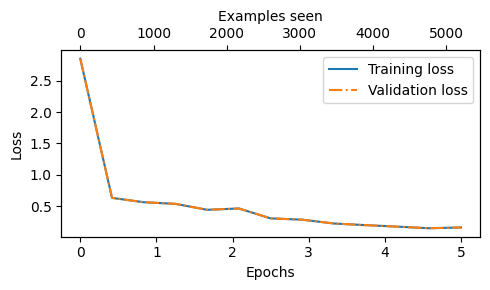

In [135]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

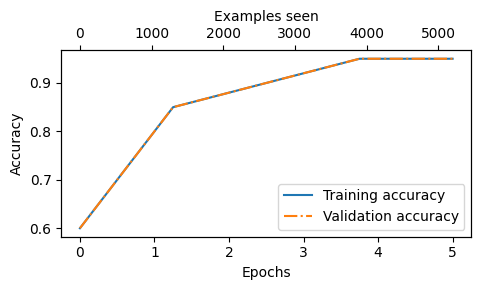

In [136]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [138]:
train_accuracy = calc_accuracy_loader(train_loader, classifier, device)
val_accuracy = calc_accuracy_loader(val_loader, classifier, device)
test_accuracy = calc_accuracy_loader(test_loader, classifier, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.22%
Test accuracy: 96.00%


In [139]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [141]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, classifier, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [142]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, classifier, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [143]:
torch.save(classifier.state_dict(), "review_classifier.pth")


In [144]:
model_state_dict = torch.load("review_classifier.pth")
classifier.load_state_dict(model_state_dict)

C:\Users\hp\AppData\Local\Temp\ipykernel_11224\592623274.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("review_classifier.pth")


<All keys matched successfully>